In [5]:
#imports
import matplotlib.pyplot as plt
 
import pandas as pd
import itertools
from itertools import combinations
import numpy as np
 
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict, RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, make_scorer
)
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

import folium 

from scipy.stats import randint

 
#loading the Dataset into a pandas dataframe
df = pd.read_csv('Airlines.csv')
allAirports = pd.read_csv('AllAirports.csv')

In [6]:
# Select features and target variable (id is not needed)
features = ['Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time', 'Length']
target = 'Delay'
X = df[features]
y = df[target]

# Preprossing of the data
encoder = preprocessing.OrdinalEncoder()
encoded = pd.DataFrame(encoder.fit_transform(X[['Airline', 'AirportFrom', 'AirportTo']]), columns = encoder.get_feature_names_out(['Airline', 'AirportFrom', 'AirportTo']))

X = X.drop(columns = ['Airline', 'AirportFrom', 'AirportTo'])
X = X.join(encoded)

# Separate continuous and categorical columns
continuous_cols = ['DayOfWeek', 'Time', 'Length']
categorical_cols = [col for col in X.columns if col not in continuous_cols]

# Instantiate MinMaxScaler
min_max_scaler = MinMaxScaler()

# Apply MinMaxScaler only to continuous columns
X[continuous_cols] = min_max_scaler.fit_transform(X[continuous_cols])

# print data frames
print(X)
print(y)

# train and test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% testing

        DayOfWeek      Time    Length  Airline  AirportFrom  AirportTo
0        0.333333  0.003499  0.312977      4.0        253.0      135.0
1        0.333333  0.003499  0.338931     14.0        217.0       60.0
2        0.333333  0.006998  0.251908      1.0        154.0       80.0
3        0.333333  0.006998  0.297710      1.0        253.0       80.0
4        0.333333  0.013996  0.308397      2.0         14.0      252.0
...           ...       ...       ...      ...          ...        ...
539378   0.666667  1.000000  0.497710      4.0        203.0      264.0
539379   0.666667  1.000000  0.465649      8.0        252.0       16.0
539380   0.666667  1.000000  0.389313      8.0        253.0      184.0
539381   0.666667  1.000000  0.477863     13.0        128.0      253.0
539382   0.666667  1.000000  0.459542     14.0        154.0      216.0

[539383 rows x 6 columns]
0         1
1         1
2         1
3         1
4         0
         ..
539378    0
539379    0
539380    0
539381    1
5

In [7]:
# Create a Random Forest classifier within a pipeline
clf = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for randomized search
param_grid = {
    'classifier__n_estimators': [10, 50, 100],
    'classifier__max_depth' : [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10, 15],
    'classifier__min_samples_leaf': [1, 2, 5, 10],
    'classifier__criterion' : ['gini', 'entropy']
}


# Setup the randomized search
random_search = RandomizedSearchCV(estimator = clf , param_distributions = param_grid, 
                                   n_iter = 15, cv = kfold, random_state=42, n_jobs = -1)

# Fit the training data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_

print(best_params)

score = cross_val_score(random_search, X_train, y_train, cv = kfold, scoring = make_scorer(accuracy_score), n_jobs = -1)
print("Cross Validated score (mean): " + str(score.mean()))

# Get the best estimator
best_estimator=random_search.best_estimator_ 

# Fit the best estimator on the full training set
best_estimator.fit(X_train, y_train)

# Make predictions on the testing set (20%)
y_pred = best_estimator.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
precision = precision_score(y_test, y_pred)
print("Precision: ", precision)
recall = recall_score(y_test, y_pred)
print("Recall: ", recall)
f1 = f1_score(y_test, y_pred)
print("F1: ", f1)

{'classifier__n_estimators': 50, 'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 10, 'classifier__max_depth': None, 'classifier__criterion': 'gini'}
Cross Validated score (mean): 0.6657543607299039
Accuracy:  0.668752375390491
Precision:  0.6558798108698968
Recall:  0.537543230967957
F1:  0.5908445543647521


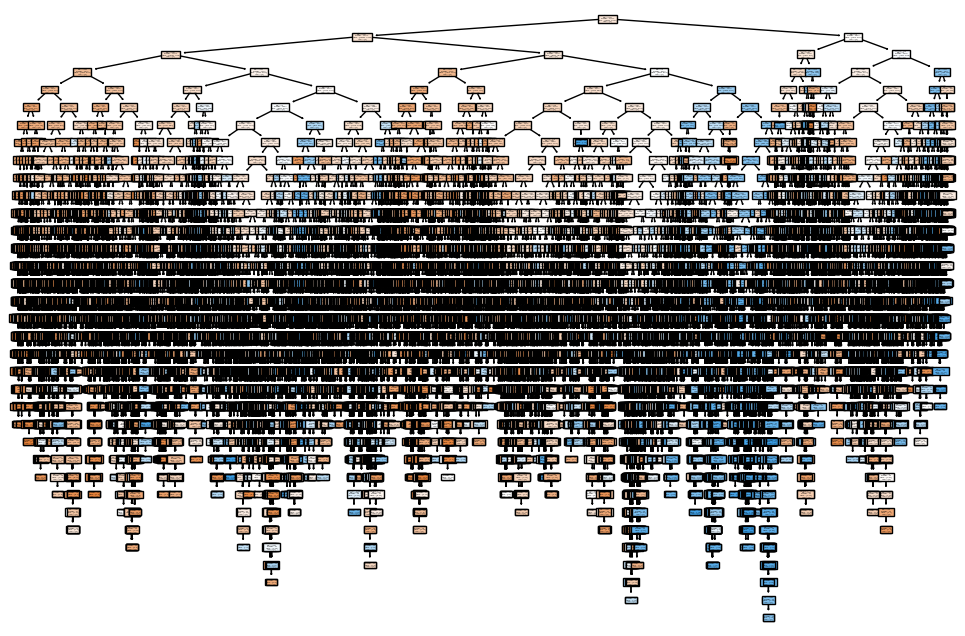

In [11]:
# Get the best tree (best performing estimator) from the Random Forest
best_tree_index = np.argmax(random_search.cv_results_['mean_test_score']) #Find index of the best tree
best_tree = best_estimator.named_steps['classifier'].estimators_[best_tree_index] # Return best tree

# Plot the best performing tree
plt.figure(figsize=(12,8))
plot_tree(best_tree, feature_names=X_train.columns, class_names=True, filled=True)
plt.show()

c:\Users\Lisa Sterner\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


<Figure size 1000x1000 with 0 Axes>

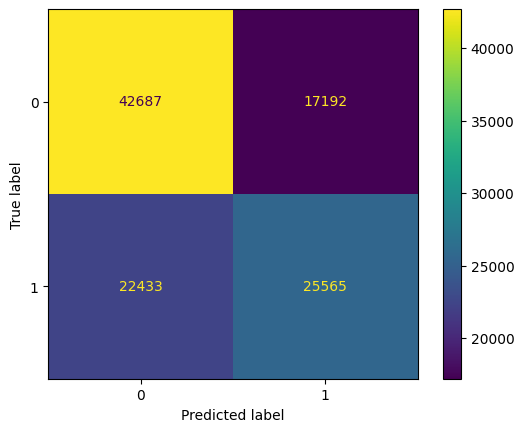

In [14]:
y_pred=best_tree.predict(X_test)

# Create confusion matrix
cm=confusion_matrix(y_test, y_pred)

# plot the cm
plt.figure(figsize=(10, 10))
ConfusionMatrixDisplay(cm).plot()
plt.savefig("Graphs/rfCM.pdf")
plt.show()

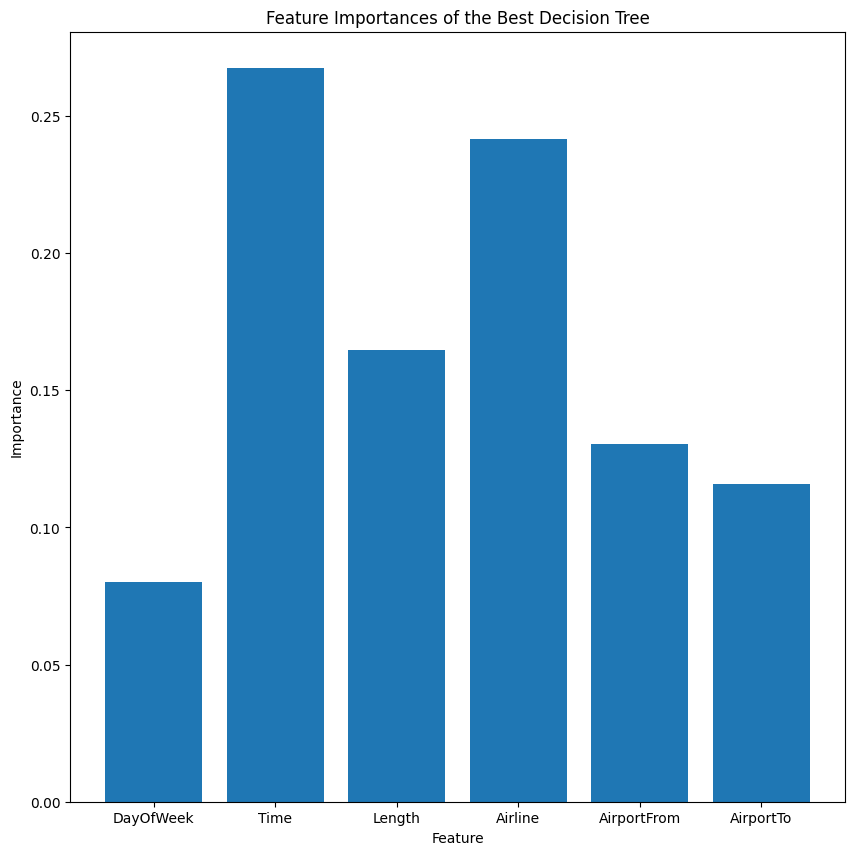

In [15]:
importanceBest = best_estimator.named_steps['classifier'].feature_importances_
# Plotte die Feature-Importances mit den Namen der Features
plt.figure(figsize=(10, 10))
plt.bar([x for x in range(len(importanceBest))], importanceBest, tick_label=X_train.columns)
plt.title('Feature Importances of the Best Decision Tree')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.savefig("Graphs/rfFeatureImportance.pdf")
plt.show()